In [1]:
import os
import sys

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.patches import Patch
from matplotlib.colors import ListedColormap

In [3]:
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

from utils import region_formatter, path_utils

In [4]:
pathUtils = path_utils.PathUtils()

In [5]:
git_root_path = pathUtils.get_git_root(os.getcwd())
dataframes_path = "{}/dataframes".format(git_root_path)

In [6]:
%run ../dataframes/provinces_gdf.ipynb -i
provinces_gdf = pd.read_pickle("{}/provinces_gdf.pkl".format(dataframes_path))

In [7]:
%run ../dataframes/asl.ipynb -i
df_asl = pd.read_pickle("{}/df_asl.pkl".format(dataframes_path))

In [8]:
%run ../dataframes/dism_first_access.ipynb -i
df_dism_first_access = pd.read_pickle("{}/df_dism_first_access.pkl".format(dataframes_path))

In [9]:
hsv_modified = cm.get_cmap('viridis', 256)
newcmp = ListedColormap(hsv_modified(np.linspace(0.7, 0.1, 256)))# show figure


/tmp/ipykernel_15893/2585086282.py:1: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  hsv_modified = cm.get_cmap('viridis', 256)


In [10]:
### Constants
OUTPUT_DIR = "output"
TARGET_GROUP = "Depressione"
TARGET_GROUP_TEXT = "Depressione"
YEAR = "2022"
# CMAP = (ListedColormap(['cyan', 'yellow', 'orange']))
CMAP = newcmp

In [11]:
plt.rcParams["figure.figsize"] = [7.50, 5.50]
plt.rcParams["figure.autolayout"] = True

In [12]:
REGION_COLOURS = {
    "Nord": "#211C6A", 
    "Centro": "#59B4C3",
    "Sud e Isole": "#74E291",
}

In [13]:
if not os.path.exists(OUTPUT_DIR):
    # Create the directory
    os.makedirs(OUTPUT_DIR)

# prepare dataframe

In [14]:
df = df_dism_first_access.loc[df_dism_first_access["gruppo_diagnostico"] == TARGET_GROUP, [
    "codice_asl", 
    "descrizione_regione",
    "sesso",
    "numero_accessi"
] ]

In [15]:
df

,codice_asl,descrizione_regione,sesso,numero_accessi
4,203,PIEMONTE,Maschio,1606
15,203,PIEMONTE,Femmina,3129
26,204,PIEMONTE,Maschio,1557
37,204,PIEMONTE,Femmina,2785
48,205,PIEMONTE,Maschio,549
...,...,...,...,...
2865,305,SARDEGNA,Femmina,344
2875,306,SARDEGNA,Maschio,70
2884,306,SARDEGNA,Femmina,128
2894,308,SARDEGNA,Maschio,604


In [16]:
df_asl = df_asl[["codice_azienda", "sigla_provincia"]]

In [17]:
provinces_gdf = provinces_gdf[["prov_acr", "geometry"]]

In [18]:
df = df.set_index("codice_asl").join(df_asl.set_index("codice_azienda"))

In [19]:
df = df.reset_index()

In [20]:
df = df.pivot_table(
    index='sigla_provincia',
    aggfunc='sum',
    values='numero_accessi'
)

In [21]:
df

,numero_accessi
sigla_provincia,
AG,1172475
AL,36030
AN,1016145
AO,279300
AP,918
...,...
VI,566707
VR,54144
VS,39221


In [22]:
df = df.join(provinces_gdf.set_index("prov_acr"))

In [23]:
df

,numero_accessi,geometry
sigla_provincia,,
AG,1172475,"MULTIPOLYGON (((13.66344 37.19338, 13.66190 37..."
AL,36030,"POLYGON ((8.40875 44.70687, 8.41158 44.70680, ..."
AN,1016145,"POLYGON ((13.42272 43.62050, 13.42363 43.62011..."
AO,279300,"POLYGON ((7.73455 45.92365, 7.73590 45.92744, ..."
AP,918,"POLYGON ((13.50521 42.77557, 13.50498 42.77545..."
...,...,...
VI,566707,"POLYGON ((11.61227 45.32540, 11.61449 45.31729..."
VR,54144,"POLYGON ((11.33151 45.38763, 11.33084 45.38717..."
VS,39221,None


In [24]:
df = df.loc[df["geometry"] == TARGET_GROUP,

numero_accessi       int64
geometry          geometry
dtype: object

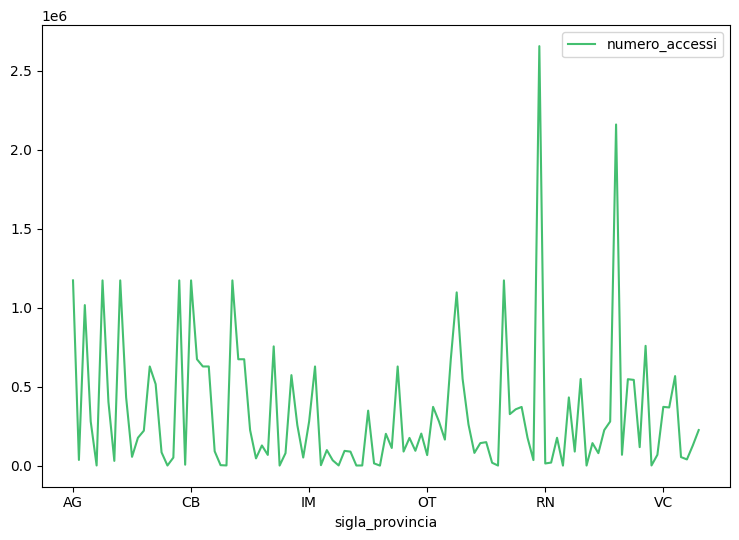

In [25]:
df.plot(
    legend=True,
    cmap=CMAP
);